# GAN Animes Images Generation

## Import librairies


In [ ]:
!pip install loguru


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
import logging
from loguru import logger

import sys
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

logger.info(f"{sys.version = }")
logger.info(f"{np.__version__ = }")
logger.info(f"{torch.__version__ = }")

2025-04-28 12:14:17.572 | INFO     | __main__:<cell line: 0>:24 - sys.version = '3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]'
2025-04-28 12:14:17.573 | INFO     | __main__:<cell line: 0>:25 - np.__version__ = '2.0.2'
2025-04-28 12:14:17.574 | INFO     | __main__:<cell line: 0>:26 - torch.__version__ = '2.6.0+cu124'


## Preparing env: load images

In [ ]:
drive.mount("/content/drive")
device_config = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
logger.info(f"{device_config = }")

2025-04-28 12:14:37.087 | INFO     | __main__:<cell line: 0>:3 - device_config = device(type='cuda', index=0)


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/IA/GAN/anime_images.zip' -d'/content/images'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/images/images/62764_2019.jpg  
  inflating: /content/images/images/62765_2019.jpg  
  inflating: /content/images/images/62766_2019.jpg  
  inflating: /content/images/images/62767_2019.jpg  
  inflating: /content/images/images/62768_2019.jpg  
  inflating: /content/images/images/62769_2019.jpg  
  inflating: /content/images/images/6276_2003.jpg  
  inflating: /content/images/images/62770_2019.jpg  
  inflating: /content/images/images/62771_2019.jpg  
  inflating: /content/images/images/62772_2019.jpg  
  inflating: /content/images/images/62773_2019.jpg  
  inflating: /content/images/images/62774_2019.jpg  
  inflating: /content/images/images/62775_2019.jpg  
  inflating: /content/images/images/62776_2019.jpg  
  inflating: /content/images/images/62777_2019.jpg  
  inflating: /content/images/images/62778_2019.jpg  
  inflating: /content/images/images/62779_2019.jpg  
  inflating: /content/

## Load dataset

In [ ]:
batch_quantity = 64
img_dimension = 64

# Create the dataset
anime_data = dset.ImageFolder(root = '/content/images',
    transform = transforms.Compose([
        transforms.Resize(img_dimension),
        transforms.CenterCrop(img_dimension),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

# Create the dataloader
data_loader = torch.utils.data.DataLoader(
    anime_data,
    batch_size = batch_quantity,
    shuffle = True,
    num_workers = 2,
    drop_last = True
)

logger.info(f"Nb batchs/{len(data_loader) = }")
logger.info(f"Nb images : {len(anime_data)}")

2025-04-28 12:17:05.476 | INFO     | __main__:<cell line: 0>:22 - Nb batchs/len(data_loader) = 993
2025-04-28 12:17:05.477 | INFO     | __main__:<cell line: 0>:23 - Nb images : 63565


## Display some images

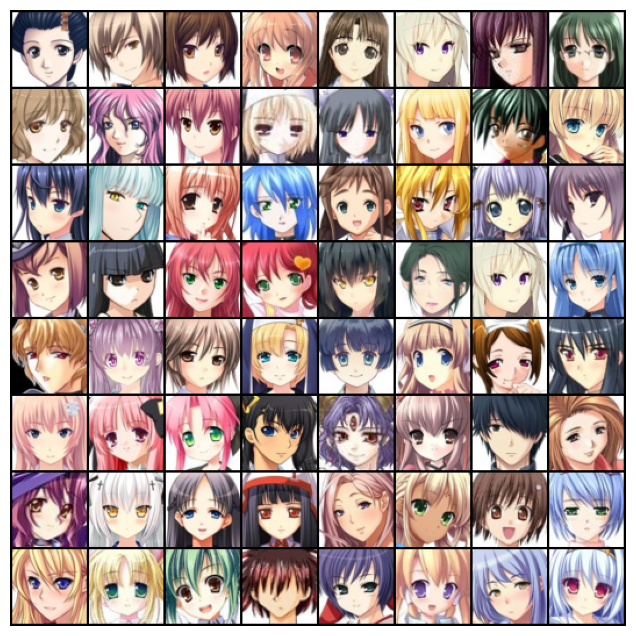

In [ ]:
def display_image_grid(images):
    images = images / 2 + 0.5
    image_grid = make_grid(images, 8)
    image_grid = image_grid.permute(1, 2, 0)
    image_grid = image_grid.cpu().numpy()
    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()

sample_batch = next(iter(data_loader))
plt.figure(figsize = (8 , 8))
plt.axis("off")

display_image_grid(sample_batch[0] )



# Models: gen and disc

## Build models


In [ ]:
def initialize_weights(module):
    module_name = module.__class__.__name__

    if module_name.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif module_name.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [ ]:
# Number of channels in the training images. For color images this is 3 (R G B)
num_channels = 3

# Size of z latent vector
z_dim = 100

# Size of feature maps in generator
gen_feature_size = 64

# Size of feature maps in discriminator
disc_feature_size = 64

# Number of training epochs
epoch_count = 50

# Learning rate for optimizers
learning_rate = 2e-4

learning_rate

0.0002

In [ ]:

class GeneratorNetwork(nn.Module):
    def __init__(self):
        super(GeneratorNetwork, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, gen_feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feature_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feature_size * 8, gen_feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feature_size * 4, gen_feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feature_size * 2, gen_feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feature_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input_data):
        return self.model(input_data)


net_generator = GeneratorNetwork().to(device_config)
net_generator.apply(initialize_weights)
logger.info(net_generator)

2025-04-28 12:17:24.986 | INFO     | __main__:<cell line: 0>:32 - GeneratorNetwork(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=

In [ ]:

class DiscriminatorNetwork(nn.Module):
    def __init__(self):
        super(DiscriminatorNetwork, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(num_channels, disc_feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feature_size, disc_feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feature_size * 2, disc_feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feature_size * 4, disc_feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feature_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        return self.model(input_data)

net_discriminator = DiscriminatorNetwork().to(device_config)
net_discriminator.apply(initialize_weights)
logger.info(net_discriminator)

2025-04-28 12:17:26.946 | INFO     | __main__:<cell line: 0>:30 - DiscriminatorNetwork(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1

In [ ]:
latent_vector = torch.randn(64, z_dim, 1, 1, device=device_config)
sample_output = net_generator(latent_vector)
logger.info(sample_output.shape)
sample_output[0]


2025-04-28 12:18:07.189 | INFO     | __main__:<cell line: 0>:3 - torch.Size([64, 3, 64, 64])


tensor([[[ 0.0065,  0.0204, -0.0281,  ...,  0.0232, -0.0338, -0.0241],
         [-0.0451,  0.0020,  0.0435,  ..., -0.0639,  0.1362, -0.0569],
         [ 0.0561,  0.0572, -0.0689,  ..., -0.0293,  0.0228, -0.1058],
         ...,
         [ 0.0572, -0.0231, -0.1588,  ..., -0.0881, -0.1048, -0.0490],
         [ 0.0111,  0.0197, -0.1268,  ..., -0.0424, -0.0832, -0.0882],
         [-0.0178, -0.0566,  0.0679,  ..., -0.0507,  0.0122, -0.0179]],

        [[ 0.0278,  0.0254, -0.0392,  ..., -0.0439,  0.0398,  0.0413],
         [-0.0365,  0.0225, -0.1735,  ...,  0.2130,  0.1493,  0.0941],
         [ 0.0242,  0.1128, -0.1675,  ...,  0.0545, -0.0820, -0.0012],
         ...,
         [-0.0690,  0.1609, -0.1243,  ...,  0.1977,  0.2523,  0.0045],
         [ 0.0663, -0.1896, -0.0068,  ..., -0.0333,  0.1671,  0.0506],
         [-0.0775, -0.0200, -0.0554,  ...,  0.0688, -0.0258,  0.0543]],

        [[ 0.0244, -0.0428,  0.0007,  ..., -0.0275, -0.0840,  0.0152],
         [-0.0302, -0.1441,  0.0005,  ...,  0

## Random generated output can be visualised individually or in batches

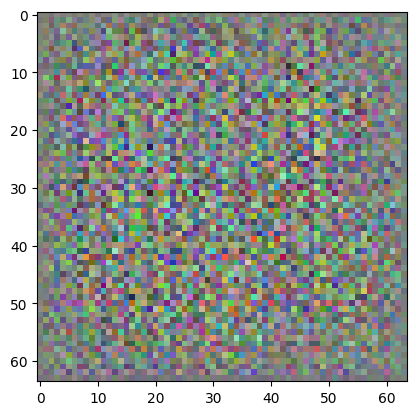

In [ ]:
plt.imshow(np.transpose(make_grid(sample_output[0].to(device_config), padding=2, normalize=True).cpu(), (1, 2, 0)))

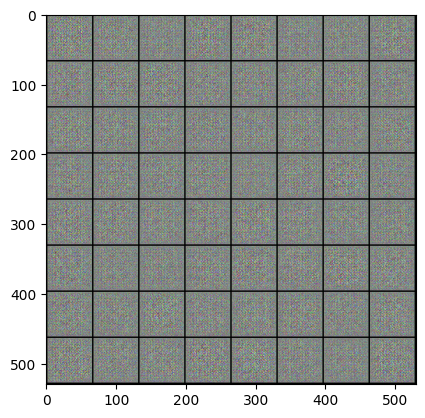

In [ ]:
plt.imshow(np.transpose(make_grid(sample_output.to(device_config), padding=2, normalize=True).cpu(), (1, 2, 0)))

In [ ]:
net_discriminator.eval()

with torch.no_grad():
    prediction = net_discriminator(sample_output)

logger.info(prediction[:5])

2025-04-28 12:18:21.403 | INFO     | __main__:<cell line: 0>:6 - tensor([[[[0.5011]]],


        [[[0.5009]]],


        [[[0.4990]]],


        [[[0.5014]]],


        [[[0.4999]]]], device='cuda:0')


## Train models

In [ ]:

loss_function = nn.BCELoss()


real_label_val = 1.
fake_label_val = 0.

optimizer_discriminator = optim.Adam(net_discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_generator = optim.Adam(net_generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
def train(epoch_count, data_loader, net_discriminator, net_generator, device_config, batch_quantity, real_label_val,
          fake_label_val, optimizer_discriminator, optimizer_generator, z_dim):
    for epoch in tqdm(range(epoch_count)):
        for idx, dataset in enumerate(data_loader, 0):

            net_discriminator.zero_grad()

            real_imgs = dataset[0].to(device_config)
            real_img_labels = torch.full((batch_quantity,), real_label_val, dtype=torch.float, device=device_config)

            real_output = net_discriminator(real_imgs).view(-1)
            disc_real_loss = loss_function(real_output, real_img_labels)
            disc_real_loss.backward()

            mean_real_score = real_output.mean().item()

            noise_vec = torch.randn(batch_quantity, z_dim, 1, 1, device=device_config)

            generated_imgs = net_generator(noise_vec)
            fake_img_labels = torch.full((batch_quantity,), fake_label_val, dtype=torch.float, device=device_config)

            fake_output = net_discriminator(generated_imgs.detach()).view(-1)
            disc_fake_loss = loss_function(fake_output, fake_img_labels)
            disc_fake_loss.backward()

            mean_fake_score = fake_output.mean().item()

            optimizer_discriminator.step()

            net_generator.zero_grad()

            output = net_discriminator(generated_imgs).view(-1)
            gen_loss = loss_function(output, real_img_labels)
            gen_loss.backward()
            optimizer_generator.step()

            if (idx % 200 == 0) or ((epoch == epoch_count - 1) and (idx == len(data_loader) - 1)):
                logger.info(f"""Epoch {epoch + 1}: - Step: {idx} |
                          D_real Loss: {disc_real_loss:.3f} |
                          D_fake Loss: {disc_fake_loss:.3f} |
                          G_Loss: {gen_loss:.3f} |
                          Real_score {mean_real_score:.3f} |
                          Fake_score {mean_fake_score:.3f}
                """)

                with torch.no_grad():
                    fake_imgs_display = net_generator(noise_vec).reshape(batch_quantity, 3, 64, 64).detach().cpu()
                    display_image_grid(fake_imgs_display)

    full_discriminator_model_path = "/content/drive/MyDrive/IA/GAN/discriminator_model.pth"
    torch.save(net_discriminator, full_discriminator_model_path)
    logger.info(f"Final Discriminator Model saved : {full_discriminator_model_path}")

    full_generator_model_path = "/content/drive/MyDrive/IA/GAN/generator_model.pth"
    torch.save(net_generator, full_generator_model_path)
    logger.info(f"Final Generator model saved : {full_generator_model_path}")



train(epoch_count, data_loader, net_discriminator, net_generator, device_config, batch_quantity, real_label_val,
          fake_label_val, optimizer_discriminator, optimizer_generator, z_dim,)

In [43]:

net_generator_loaded = torch.load("/content/drive/MyDrive/IA/GAN/generator_model.pth", weights_only=False)
logger.info(net_generator_loaded.eval())
logger.info("Generator model loaded.")


net_discriminator_loaded = torch.load("/content/drive/MyDrive/IA/GAN/discriminator_model.pth", weights_only=False)
logger.info(net_discriminator_loaded.eval())
logger.info("Discriminator model loaded.")


2025-04-28 13:38:35.431 | INFO     | __main__:<cell line: 0>:2 - GeneratorNetwork(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(

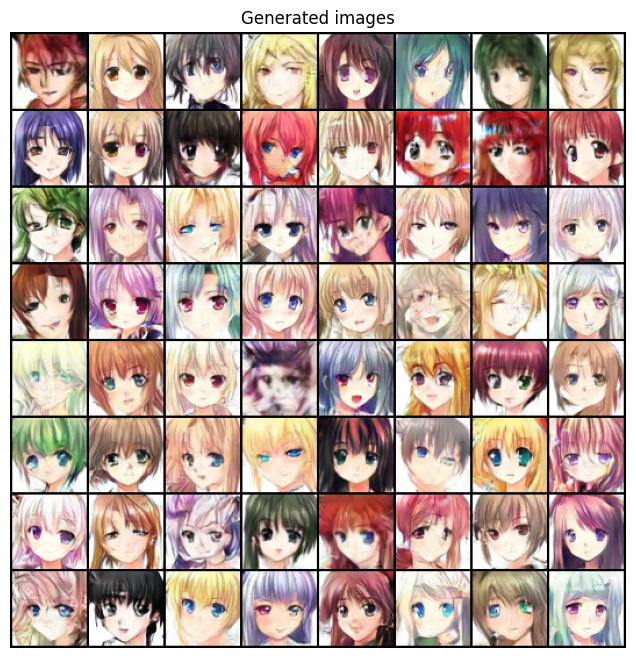

In [46]:
noise_vec = torch.randn(64, z_dim, 1, 1, device=device_config)

new_generatedimgs = net_generator_loaded(noise_vec).reshape(64, 3, 64, 64).detach()
plt.figure(figsize = (8 , 8))
plt.axis("off")
plt.title("Generated images")

display_image_grid(new_generatedimgs)

In [48]:

prediction = net_discriminator_loaded(new_generatedimgs)

mean=prediction.mean().item()
std=prediction.std().item()
p_max = prediction.max().item()
idx_max = prediction.argmax().item()
logger.info(f"Mean proba = {mean:5f}")
logger.info(f"Std = {std:5f}")

logger.info(f"Max proba = {p_max:02f}")
logger.info(f"iMax proba (image id/num) = {idx_max}")


2025-04-28 13:43:24.136 | INFO     | __main__:<cell line: 0>:7 - Mean proba = 1.000000
2025-04-28 13:43:24.137 | INFO     | __main__:<cell line: 0>:8 - Std = 0.000000
2025-04-28 13:43:24.138 | INFO     | __main__:<cell line: 0>:10 - Max proba = 1.000000
2025-04-28 13:43:24.139 | INFO     | __main__:<cell line: 0>:11 - iMax proba (image id/num) = 0


In [50]:
prediction.mean().item()

1.0